from

https://www.kaggle.com/dansbecker/use-cases-for-model-insights

dataset

https://www.kaggle.com/mathan/fifa-2018-match-statistics




# Use cases for model insights

## What types of insights are possible:
- remember, ML models remain "black boxes"...
- you can extract some information:
    - what features in the data did the model think are most important?
    - for any single prediction from a model, how did each feature in the data affect that particular prediction?
    - how does each feature affect the model's predictions in a big-picture sense?
    
## Useful why?
- debugging
    - data is dirty, preprocessing adds a potential source of errors
    - target leakage: when predictors include data that will not be available at the time you make predictions.
- informing feature engineering
    - feature engineering with 100s of features require more than just intuition generally
- directing future data collection
    - model-based insights give you a good understanding of the value of features you curently have, which will help you reason about what new values may be most helpful
- informing human decision-making
    - many important decisions are made by humans, for whom insights could be more valuable than predictions
- building trust
    - can only trust a model if you know how it behaves - not just the end results...

## Permutation Importance

- shows which feature most affect predictions
- feature importance = which features have the biggest impact on predictions?
- permutation importance: fast, easy to understand

### How it works
- after a model has been fitted
- if i randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how could that affect the accuracy of rpedictions in that now-shuffled data?
    - should cause less accurate predictions if the model relied on that column for predictions.`

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import os

In [2]:
import eli5

Using TensorFlow backend.
C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\theop\Anaconda3\envs\env_i

In [3]:
data = pd.read_csv("FIFA 2018 Statistics.csv")

In [73]:
y = (data["Man of the Match"]=="Yes")
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [74]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(train_X, train_y)

In [75]:
perm = eli5.sklearn.PermutationImportance(model_forest, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


### Interpreting Permutation Importances
- top values = most important
- 1st number of a row = how much model perfromance decreased with a random shuffling (using accuracy as the performance metric)
- should repeat the measurements with multiple shuffles --> +/- variance
- negative values --> predictions are more accurate with shuffled data --> feature didn't matter (usually only happens if the dataset is small)

## Partial dependence plots
- show how a feature affects prediction


### How:
- after model has been fitted
- start by considering a single row of data, e.g. soccer: possession, number of passes, shots taken, goals scored, want to predict probability that player won "man of the match".
- Use fitted model to prredict outcome, but we repeatedly alter the value for one variable:
    - predict outcome if the team had the ball 40% of the time; then do the same for 50% time, etc...
    - trace out predicted outcomes on vertical axis as we move from small values of ball possession to larger ones (horizontally)

In [76]:
from sklearn import tree
import graphviz

In [77]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5,min_samples_split=5).fit(train_X, train_y)

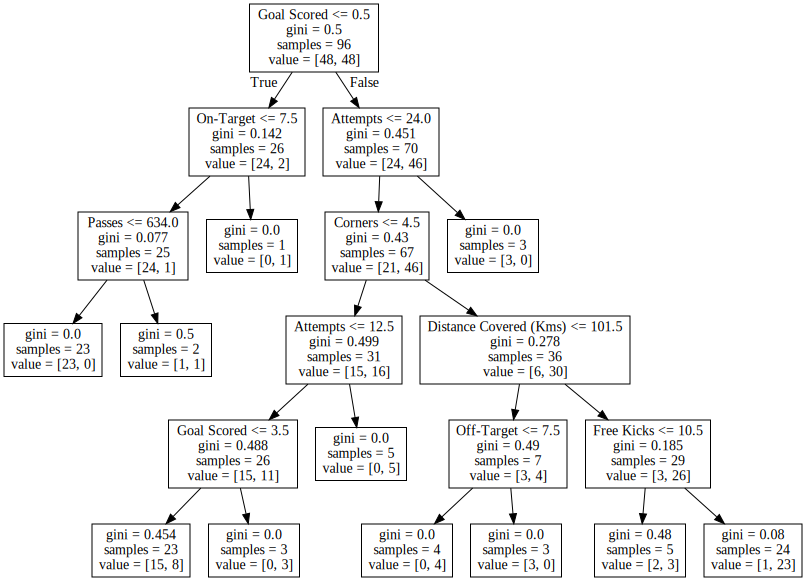

In [78]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

In [79]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

C:\Users\theop\Anaconda3\envs\env_ipynb\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


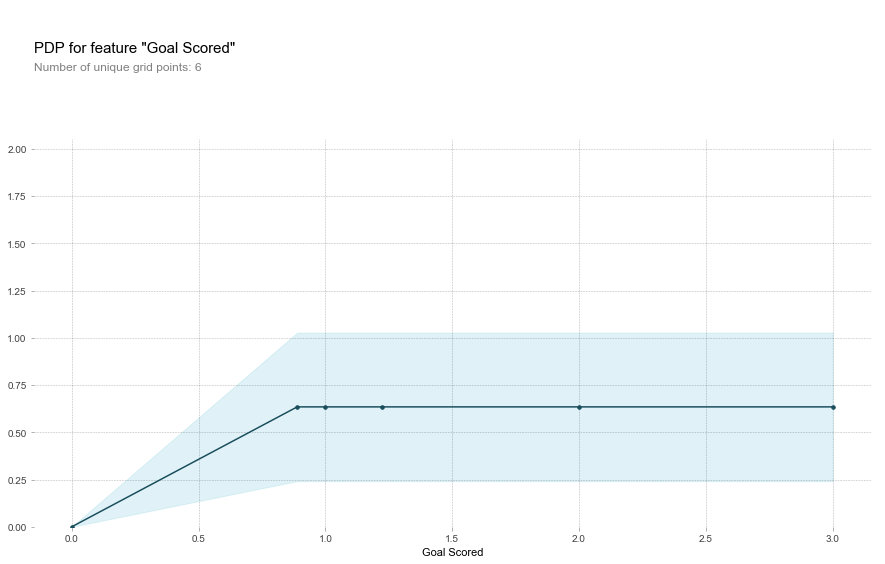

In [80]:
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature="Goal Scored")
pdp.pdp_plot(pdp_goals, "Goal Scored")
plt.show()

- y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
- shade = level of confidence
- scoring a goal increases your chance of winning man of the match

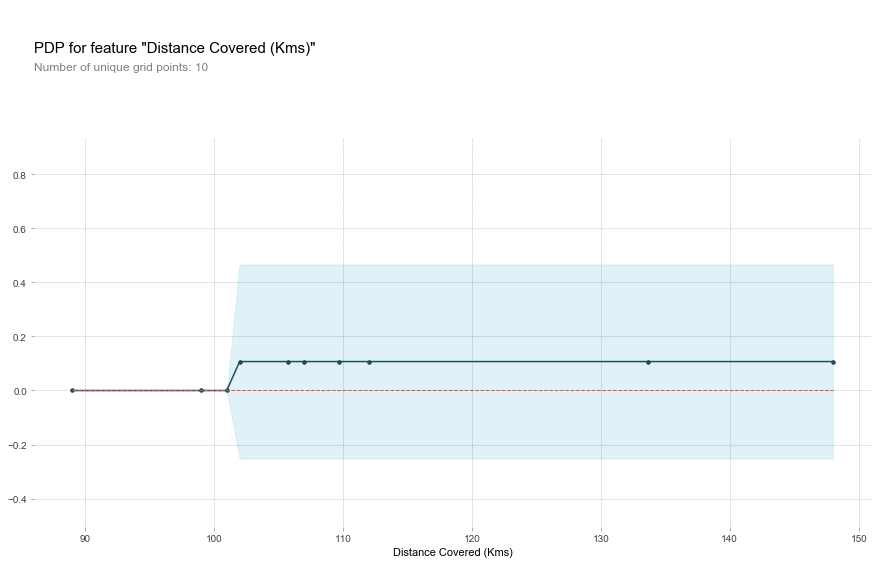

In [81]:
feature_to_plot = "Distance Covered (Kms)"
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

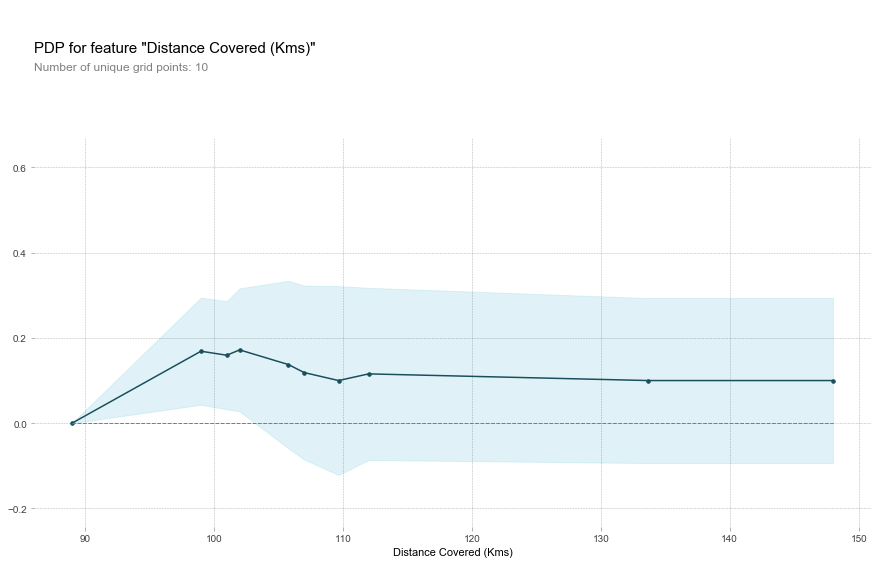

In [82]:
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

### 2D Partial Dependence Plots
- use decision tree model

In [83]:
inter1 = pdp.pdp_interact(model=titanic_model,
                          dataset=titanic_data,
                          model_features=titanic_features,
                          features=['Age', 'Fare'],
                          num_grid_points=[10, 10],
                          percentile_ranges=[(5, 95), (5, 95)])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1,
                                  feature_names=['age', 'fare'],
                                  plot_type='contour',
                                  x_quantile=True,
                                  plot_pdp=True)

NameError: name 'titanic_model' is not defined

In [ ]:
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=tree_model, 
                            dataset=val_X, 
                            model_features=feature_names, 
                            features=features_to_plot,
                            num_grid_points=[20,20])
# try using contour instead of grid
pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                      feature_names=features_to_plot, 
                      plot_type='grid',
                      x_quantile=True,
                      plot_pdp=True)
plt.show()

- highest predictions: team scores at least 1 goal, and run total distance at least 100 km. If they score 0 goals, distance doesn't matter. Makes sense when we look at the decision tree and we choose "no goals".
- distance can impact predictions if they score goals.

## SHAP values

- Shapley additive explanations
- explain individual predictions

### How they work:
- instead of saying "how much was a prediction driven by the fact that the team scored 3 goals? 
    - ask: "how much was a prediction driven by the fact that the team scored 3 goals instead of some baseline number of goals?
- sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values
    - the SHAP values of all features sum up to explain why my prediction was different from the baseline
- if you predict 0.7, but the base value is 0.479: feature values causing increased predictions
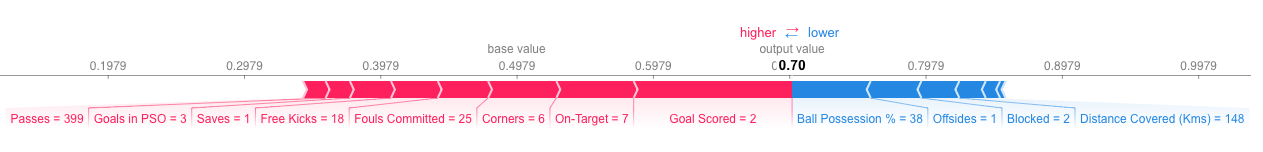
    - blue: features that decrease prediction
    - if you subtract the lenght of blue bars from the length of pink bars: equals distance from base value to output (prediction)
    

In [84]:
import shap

In [85]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
model_forest.predict_proba(data_for_prediction_array)

array([[0.29, 0.71]])

- team is 70 % likely to have player win the award

In [86]:
explainer = shap.TreeExplainer(model_forest)
shap_values = explainer.shap_values(data_for_prediction)

- list of two arrays: first = SHAP values for negative outcome, 2nd for positive outcome
    - usually just consider only one of those two

In [87]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1],data_for_prediction)

- above: only possible for 1 prediction ! this is only for 1 prediction!!!!
- red features caused an increase in the predictions (here we have only taken a look at "positive" outcomes = winning the award)
- blue caused decrease
- biggest impacts: goal scored = 2, and ball possession=38%
- we can see that overall, the prediction is above the base value

- can use with Deep learning models (DeepExplainer), or all models (KernelExplainer) - but that one is slower and gives approximate results

## Advanced uses of SHAP values

- aggreagate many SHAP values can give more detailed alternatives to permutation importance and partial dependence plots:
    - can give more than a "1 instance" explanation, more like a "local" explanation

### Review:
- shows how much a feature changed the prediction, compared to if we made that prediction at some baseline vlaue of that feature.
- consider: $y = 4 * x1 + 2 * x2$
- if x1 takes value 2 instead of baseline value 0, then the SHAP value for x1 is 4*2=8


### Summary Plots
Issues with permutation: a medium permutation importance could mean 
- large effect for a few predictions, no effect in general
- medium effect for all predictions
   
SHAP visualization: 

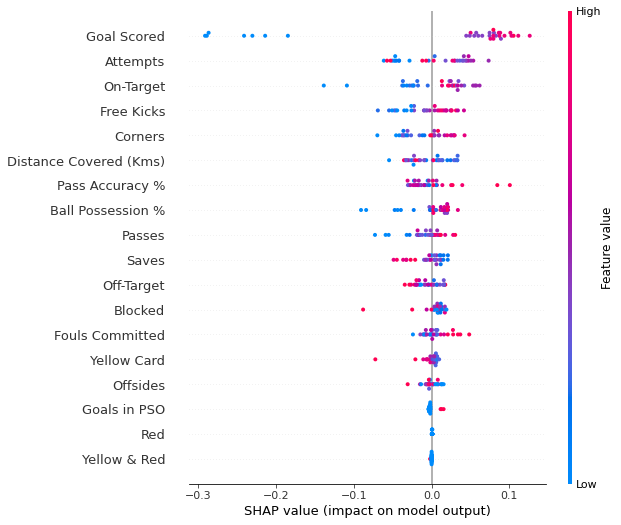
plot: dots
- vertical location = which feature
- color = if feature is high or low for that row of the dataset
- horizontal location = effect of the value on the prediction (higher or lower w.r.t. baseline)

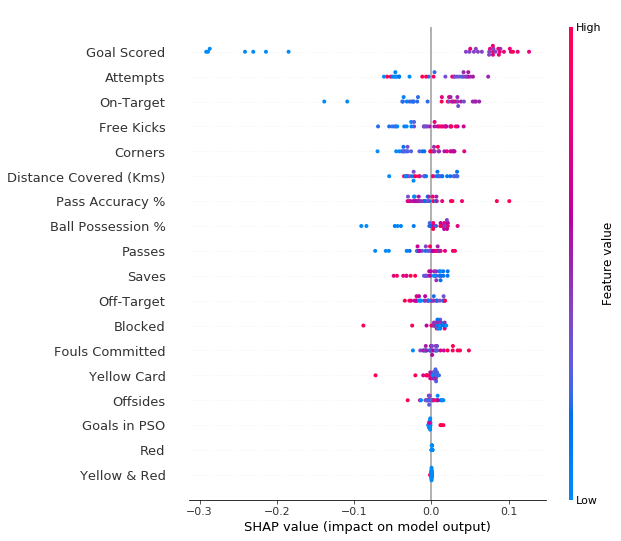

In [88]:
shap_values = explainer.shap_values(val_X)
shap.summary_plot(shap_values[1], val_X)

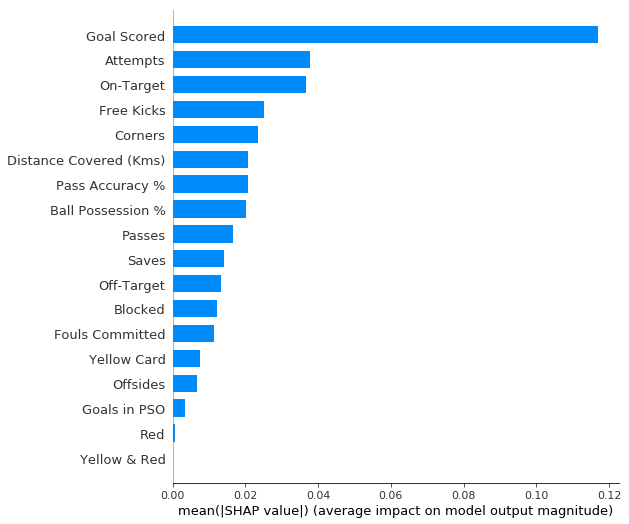

In [89]:
shap.summary_plot(shap_values[1], val_X, plot_type = "bar")

above: absolute SHAP value... while above above, not absolute.

- slow
- optimized for xgboost however

### SHAP dependence contribution plots

PDP are great, can show how a single feature impacts predictions. 
- they don't show the distribution of effects: is the effect of having a certain value pretty constant? or does it vary a lot?
    
SHAP plots:
- 1 dot = 1 data row
    - horizontal location = actual value from dataset
    - vertical location = shows what having that value did to the prediction (vs. baseline)
    - in example below: slopes upward --> the more you possess the ball, the higher, the higher the model's prediction is for winning the man of the match award
    - spread suggests that other features must interacta with Ball possession: take two points with similar ball possession values: 1 caused prediction to increase, the other one to decrease.
    - color: indicates the value of the data point (vs. other values: high/low). Here: usually having the ball increases the team's chance of having their player win the award, however if they score one goal only, that trend reverses, and the judges may penalize them for having the ball so much while scoring so little.

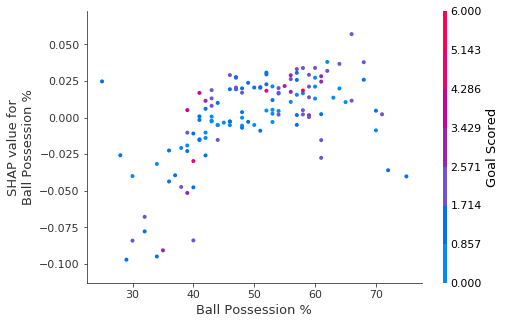

In [90]:
shap_values = explainer.shap_values(X)
shap.dependence_plot("Ball Possession %", shap_values[1], X, interaction_index = "Goal Scored")

## MORE:
check : https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

from 
https://towardsdatascience.com/interpreting-your-deep-learning-model-by-shap-e69be2b47893

# Interpreting your deep learning model by SHAP

## Shapley value
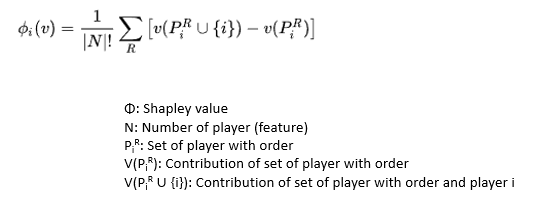

- example: 3 data scientists need to deliver a model containing 100 lines of codes
![](https://miro.medium.com/max/246/1*ArZVijQ-I_nNpn-0pukSpg.png)
- above: contribution among all possible coalittions
![](https://miro.medium.com/max/700/1*DLL5sCQKeVXboAYIvdgwUw.png)
- above: computations of contributions per coalition of independent players
![](https://miro.medium.com/max/547/1*uGjQRe9U0ebC5HxYXAzg3A.png)
- above: overall contribution of a player (average of all possible coalitions) = Shapley value


Although M contributed 6 times more lines than N, the payout is respectively 41.7 and 34.17...

from 

https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b


# A novel approach to Feature Importance - Shapley Additive Explanations (SHAP)

- e.g. with 3 basketball players A, B, C: compute how much they help score
- 1 approach: compute team's performance with and without player A
    - estimate how important a model is by seeing how well the omdel performs with and without that feature, for EVERY combination of features.
    - SHAP: local feature importance, not global.

Example
- player A importance
    - step 1: combination of B and C without A: take an average of points scored in games with this combination
    - step 2: combination of A, B, and C
    - difference: say 20 points.

from

https://en.wikipedia.org/wiki/Confidence_interval
    
# Confidence Interval
- type of estimate computed from statistics of observed data
- proposes a range of plausible values for an unknown parameter.
- the interval has an associated confidence level that the true parameter is in the proposed range
- given observations x1, ... , xn and a confidence level gamma, a valid confidence interval has a probability gamma of containing the true underlying parameter
- the "95%" probability relates to the reliability of the estimation procedure - not to a specific calculated interval.
    - a 95% CI does NOT mean that for a given realized interval there is a 8%% probability that the propulation parameter lies within the interval....
    
    
from

https://machinelearningmastery.com/confidence-intervals-for-machine-learning/

# Confidence intervals for Machine Learning
### confidence interval
- is a bounds on the estimate of a population variable. It is an internal statistic used to quantify the uncertainty of an estimate.

### interval for classification accuracy
- accuracy = total correct / total * 100
- classification: predictions are correct / not --> Bernoulli trials: binomial distribution. This distribution can be approximated by a Gaussian with a large enough sample size.
- for classification error: interval = z * sqrt((error * (1-error))/n)
- for classification accuracy: interval = z * sqrt((accuracy*(1-acuracy))/n)
- for 95% CI, z = 1.96 and for a model with 20% error, and n =50, we get
    - 1.96*sqrt((0.2*(1-0.2))/50) = 0.111
    - classification error of the model is 20% +/- 11%
    - if we repeated this experiment an infinity of times, each time drawing a new sample containig new examples, we would find that for approximately 95% of these experiments the computed interval would contain the true error.
    
### Non-parametric Confidence Interval
- if we don't know the distribution of a chosen measure, or the way to compute an interval for that.
--> Bootstrap resampling method

Bootstrap resampling method: simulated Monte Carlo method where samples are drawn from a fixed finite dataset with replacement, and a paremeter is estimated on each sample. This procedure leads to a robust estimate of the true population parameter via sampling.

In [ ]:
stats = []
for i in bootstraps:
    sample = select_sample_with_replacement(data)
    stat = compute_stat(sample)
    stats.append(stat)    

- percentile = observation value drawn from the sorted sample where a percentage of the observations in the sample fall: 70th percentile = 70% of the data samples fall below that value.
- CI is symmetric around the median, so for a 95% CI =^ 100-95% percentile, we want to choose observations at the 2.5th and 97.5th percentiles.
- example: dataset of 1000 observations with values between 0.5 and 1 drawn from a uniform distribution

In [59]:
import numpy as np

In [64]:
dataset = np.random.uniform(0.5, 1, 1000)

# bootstrap
scores = list()
for i in range(100):
    indices = np.random.randint(0, 1000, 1000)
    sample = dataset[indices]
    statistic = np.mean(sample)
    scores.append(statistic)
median_scores = np.median(scores)
print(median_scores)

0.751838872825952


In [67]:
# compute CI as the middle 95% of observed statistical values centered around median
alpha = 0.5
# 2.5th
lower_p = alpha/2.0
lower = max(0.0, np.percentile(scores, lower_p))
upper_p= (100-alpha)+(alpha/2)
upper=min(1.0, np.percentile(scores, upper_p))

In [68]:
print(lower, upper)

0.7434673132765328 0.7667648069544866


There is a 95% likelihood that the range of lower, upper covers the true statistic mean.

from 

https://towardsdatascience.com/various-ways-to-evaluate-a-machine-learning-models-performance-230449055f15

# Various ways to evaluate a machine learning model's performance

- COnfusion matrix: TP, FN, FP, TN
- accuracy: (TP+TN)/(TP+FP+TN+FN)
- precision: how much the model is right when it says it is: TP/(TP+FP)
- recall (sensitivity): how much right did the model miss: TP/(TP+FN)
- specificity: TN/(TN+FP)
- F1 score: harmonic mean of precision and recall
- PR curve: precision vs recall
- ROC curve: receiver operating characteristic: true positive rate vs. false positive rate so recall vs (1-specificity). You want the curve to be pushed to top left.
- AUC is the are under the curve: AUROC

from

https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a
    
# Boruta explained exactly how you wished someone explained to you

- aim : simplify problem by removing unuseful features which introduce unnecessary noise
- usually: compute feature importance and select those deemed important--> rely on a threshold, which is often totally arbitrary....

In [12]:
import pandas as pd
import numpy as np

In [30]:
X = pd.DataFrame({"age":[25,32,47,51,62],
                 "height":[182,176,174,168,181],
                 "weight":[75,71,78,72,86]})
y = pd.Series([20,32,45,55,61], name =  "income")

## shadow features:
- features do not compete among themselves, they compete with a randomized version of them. These permuted features = shadow.
- then fit a random forest on X_boruta and y
- feature importance: define threshold as the highest feature importance recorded among the shadow features. If the importance is higher than the threshold --> "hit"
    - feature is useful ONLY if it is able of doing better than the best randomized feature...

In [31]:
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ["shadow_"+ name for name in X.columns]
X_boruta = pd.concat([X, X_shadow], axis=1)

In [32]:
X_boruta.head()

,age,height,weight,shadow_age,shadow_height,shadow_weight
0,25,182,75,51,176,75
1,32,176,71,32,182,71
2,47,174,78,47,168,78
3,51,168,72,25,181,72
4,62,181,86,62,174,86


In [33]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
import warnings

In [56]:
warnings.filterwarnings(action='ignore')

hits = np.zeros((len(X.columns)))

for i in range(20):
    np.random.seed(i)
    X_shadow = X.apply(np.random.permutation)
    X_boruta = pd.concat([X, X_shadow], axis=1)
    
    forest = RandomForestRegressor(max_depth=5, random_state=42)
    forest.fit(X_boruta, y)

    feature_imp_X = forest.feature_importances_[:len(X.columns)]
    feature_imp_shadow_X = forest.feature_importances_[len(X.columns):]

    hits += (feature_imp_X > feature_imp_shadow_X.max())
warnings.filterwarnings(action="once")

In [57]:
hits

array([10.,  0., 15.])

- max uncertainty of binary: is important / not: 50%
    - binomial distribution
- no hard threshold

![](https://miro.medium.com/max/700/1*yqAUlMtPUiFyr8gYLFagTA.png)

- red area: refusal: features here are considered as noise
- green area: acceptance: features here are considered as predictive
- blue area: irresolution
- define areas by selecting tails of the distribution

In [58]:
import scipy as sp

In [61]:
pmf = [sp.stats.binom.pmf(x, 20, .5) for x in range(20+1)]

In [65]:
import matplotlib.pyplot as plt

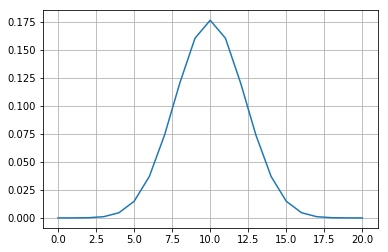

In [69]:
plt.grid(True)
plt.plot(range(21), pmf)

from

https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d
    
# One feature attribution method to (supposedly) rule them all: shapley values

## intro
- need to try all different orders, because imagine payoff =11, 3 players.
    - A brings payoff to 5, B to 10, C to 11. So contributions in that order are 5, 5, 1
    - what if they have overlapping "skills", meaning that C maybe provides something B already provided so it doesn't impact the payout...? So need to compute every possible order.
    - find each player's marginal contribution, averaged over every possible sequence im which the players could have been added to the group.
    - the whole point is to average marginal contribution over ALL sequences --> weight subset calculation according to how many sequences it represents.
- however, be smart: if 5 players A, B, C, D, E: evaluate C:
    - the sequence A, B, C, D, E and B, A, C, D, E don't matter from the point of view of B... and D and E don't matter either
    - evaluate for f(AB)

## some axoms:
- if a player never adds any marginal value their payoff should be 0 (dummy player)
- if two players always add the same marginal value to any subset to which they're added, their payoff portion should be the same (substitutability)
- if a game is composed of two subgames, you should be able to add the payoffs calculated on the subgames, and that should match the payoffs calculated for the full game (additivity)

## LIME
- seeks to explain an individual prediction from a model by choosing interpretable features sampling, and then building a linear model focused in the local region around that instance.
- local approximation is done through kernels. They take in two vectors and return a measure of similarity (high if points are similar)
--> sample points by permuting input vector, then weight those samples by the value of some kernel calculated between the sample and input, which means you place more weight on samples that are highly similar to the input.
 

## LIME and Shapley values
- weight the LIME samples (which contain subsets of the features present in whichever instance we're trying to predict) based on a kernel that represents the number of feature-addition sequences that a given subset accounts for.
    - estimate the values based on some set of samples rather than calculating them exaclty. Not perfect but faster.
    
#### Shapley additive explanations
- model agnostic shap : https://github.com/slundberg/shap

from

https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5
    
# Describing your Machine Learning model using LIME

- problem with current model explainability: hard to define amodel's decision boundaey in a human understandable manner.

### importance of trusting the model
- run multiple cross-validations, perform hold-out set validation
    - gives view of model performance over unseen data
    - what about seen data, how can we explain the behavior?

### What's LIME
Local interpretable Model-agnostic Explanations
- model agnostic: should not make any assumptions about the model
- allows to select a "representative set with explanations" using SP LIME
- interpretable:: provide a qualitative understanding of input-->output
- local fidelity: should be able to replicate model's behavior in vicinity of instance being predicted
- global perspectives: should explain a representative set to the user so that the user has a global intuition of the model
    
    
### What makes LIME a good model explainer?
- irrespective of actual features

Fidelity interpretability trade-off: minimize (L(f, g, pi_x) + omega(g)) where
- f = original predictor
- x = original features
- g = explanation model 
- Pi = proximity measure between an instance of z to x to define locality around x.
- first term: locality-aware loss: measure of unfaithfulness of g in approximating f in the locality defined by Pi. it weighs z'(perturbed instances) depending on their distance from x.
- second term: measure of model complexity of explanation g. 

- x' = binary vector, human understandable version of the actual features used by original features
- z' = fraction of non zero elements of x'
- f(z) = class label (the "y")
- g(z') = model learned by LIME (the model to learn)

Sampling for Local Exploration:
- in order to create a complete training set, we perform random uniform sampling from x' --> create multiple z' from a single row of x (original training example). These are weighed by Pi(x) to focus more on z' that are closer to x. 


#### SP-LIME:
Submodular Pick LIME

### Example

In [4]:
import lime
import pandas as pd
import numpy as np
import lightgbm as lgb

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
data_lime = data.fillna(0)
le = LabelEncoder()

In [7]:
features = ['Team_le', 'Opponent_le', 'Goal Scored', 'Ball Possession %']

In [8]:
data_lime["Team_le"] = le.fit_transform(data_lime["Team"])
data_lime["Opponent_le"] = le.fit_transform(data_lime["Opponent"])
data_lime["Man of the Match_le"] = le.fit_transform(data_lime["Man of the Match"])

In [9]:
data_lime.head(1)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time,Team_le,Opponent_le,Man of the Match_le
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,Yes,12.0,Group Stage,No,0,0.0,0.0,23,24,1


In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
y = data_lime["Man of the Match_le"]
X = data_lime[["Team_le","Opponent_le","Goal Scored","Ball Possession %"]]
X_featurenames= X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lime_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators =10)
lime_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [12]:
from lime import lime_tabular

In [13]:
explainer= lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                 feature_names=X_featurenames,
                                                 class_names=["Goal Scored"],
                                                 categorical_features=["Team_le","Opponent_le"],
                                                 mode="regression")

C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
import matplotlib.pyplot as plt

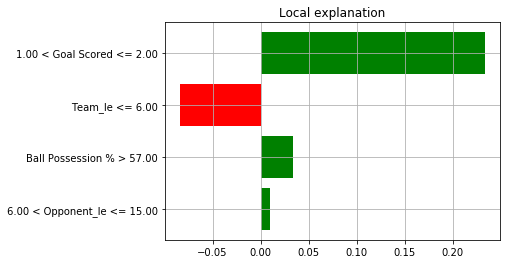

In [15]:
exp = explainer.explain_instance(X_test.iloc[0], lime_model.predict)
exp.as_pyplot_figure()
plt.grid()
plt.show()

- green / red color: features that have positive correlations with the target are shown in green, otherwise red
- ball possession values over 48 but under 57 have a great positive correlation
- opponent team has a small negative correlation

In [16]:
exp.show_in_notebook(show_table=True, show_all=True)

https://machinelearningmastery.com/confidence-intervals-for-machine-learning/#:~:text=Much%20of%20machine%20learning%20involves,the%20uncertainty%20of%20an%20estimate.&text=That%20a%20confidence%20interval%20is,estimate%20of%20a%20population%20parameter.

## Confidence intervals

- CI = bounds on the estimate of a population variable. 
    - — Page 3, Statistical Intervals: A Guide for Practitioners and Researchers, 2017 : A confidence interval to contain an unknown characteristic of the population or process. THe quantity of interest might be a population property or "parameter", such as the mean or standard deviation of the population process.
- tolerance interval = describes the bounds of data sampled from the distribution.
- prediction interval = describes the bounds on a single observation
- the error of the model was x +/- y at the 95% Confidence level
    - — Page 4, Introduction to the New Statistics: Estimation, Open Science, and Beyond, 2016.: the 95% confidence interval is a range of values calculated from our data, that most likely, includes the true value of what we're estimating about the population.
     - Page 4, Introduction to the New Statistics: Estimation, Open Science, and Beyond, 2016.: We can also say the the CI tells us how precise our estimate is likely to be, and the margin of error is our measure of precision. A short CI means a small margin of error and that we have a relatively precise estimate. [...]A long CI means a large margin of error and that we have a low precision.
- allows to quantify the uncertainty of an estimate. provides upper/lower bound + likelihood. Can be referred to as margin of error when not considering the likelihood (-->error bars).
- — Page 416, Applied Predictive Modeling, 2013.: These estimates of uncertainty help in two ways. First, th eintervals give the consumers of the model an understanding about how good or bad the model may be [...]. In this way, the confidence interval helps gauge the weight of evidence available when comparing models.The second benefit of the confidence intervals is to facilitate trade-offs between models. If the confidence intervals for two models signficantly overlap, this is an indication of (statistical) equivalence between the two and might provide a reason to favor the less complex or more interpretable model.


#### Classification accuracy, intervals
Classification accuracy or classification error is a proportion or a ratio. It describes the proportion of correct or incorrect predictions made by the model. Each prediction is a binary decision that could be correct or incorrect. Technically, this is called a Bernoulli trial, named for Jacob Bernoulli. The proportions in a Bernoulli trial have a specific distribution called a binomial distribution. Thankfully, with large sample sizes (e.g. more than 30), we can approximate the distribution with a Gaussian.

In statistics, a succession of independent events that either succeed or fail is called a Bernoulli process. […] For large N, the distribution of this random variable approaches the normal distribution.

— Page 148, Data Mining: Practical Machine Learning Tools and Techniques, Second Edition, 2005.


Remember that the confidence interval is a likelihood over a range. The true model skill may lie outside of the range.

In fact, if we repeated this experiment over and over, each time drawing a new sample S, containing […] new examples, we would find that for approximately 95% of these experiments, the calculated interval would contain the true error. For this reason, we call this interval the 95% confidence interval estimate

— Page 131, Machine Learning, 1997.



The assumptions that underlie parametric confidence intervals are often violated. The predicted variable sometimes isn’t normally distributed, and even when it is, the variance of the normal distribution might not be equal at all levels of the predictor variable.

— Page 326, Empirical Methods for Artificial Intelligence, 1995.

In these cases, the bootstrap resampling method can be used as a nonparametric method for calculating confidence intervals, nominally called bootstrap confidence intervals.




In [ ]:
should look into k-fold cross - validation
- always use test set even with crossval

In [11]:
451+265*1.9*2

1458.0